# Bidirectional LSTM (BiLSTM) -- Multivariate / Univeraite Multi-Step Forecast
---

## COVID-19 Canada Forecast of Cases and Deaths

- Daily forecast (in figure): predicting daily numbers (the following 28 daily numbers)

- Weekly forecast (in figure): predicting weekly numbers directly (the following 4 weekly numbers)

- Weekly report (in table): 4 total numbers for 4 weeks, each week is from StartDate to Date

- weekday: Mon = 1, Tue = 2, ..., Sun = 7


Data source: [OxCGRT Data](https://github.com/OxCGRT/covid-policy-tracker/tree/master/data)

Author: Jianfei Zhang (jianfei.zhang@ualberta.ca)

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential, layers
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [2]:
def load_OxCGRT():
    path = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
    d = pd.read_csv(path, parse_dates=['Date'], low_memory=False)
    d[['CountryName', 'RegionCode']] = d[['CountryName', 'RegionCode']].fillna('')
    d['Cases'], d['Deaths'] = d.ConfirmedCases.fillna(0), d.ConfirmedDeaths.fillna(0)
    d['Date'] = pd.to_datetime(d['Date'], format='%m/%d/%y')
    return d

def get_df(d, CountryName, RegionCode = ''):
    d = d[(d['CountryName'] == CountryName) & (d['RegionCode'] == RegionCode)].copy()
    d = d.set_index(['Date'])
    return d

In [3]:
def Series2Xy(d, target, var, slides, lookbacks, gap, pred_steps, is_multivariate):
    '''
    Transform the time series to supervised data 
        - d: dataframe
        - target: the target to predict, a 1D list of column name in df, e.g., ['Cases']
        - var: the list of covariates
        - sildes: the steps that sliding window moves forward
        - lookbacks: how many previous steps used, e.g., using X = [1, 2, 3] to predict y = [1, 2], 3 lookbacks
        - gap: the steps between X and y
        - pred_steps: how long the output y is, e.g., y = [1, 2] means 2 pred_steps 
        - is_multivariate: if using multivariate or univariate
    '''
    X, y = [], []
    d_target = np.array(d[target])
    for i in range(lookbacks + (gap - 1) + pred_steps, len(d), slides):
        X_target = d_target[i - lookbacks - (gap - 1) - pred_steps: i - (gap - 1) - pred_steps]
        if is_multivariate:
            X_var = np.array(d[var])[i - lookbacks - (gap - 1) - pred_steps: i - (gap - 1) - pred_steps]
        else:
            X_var = np.array([], dtype=np.int64).reshape(lookbacks, 0)
        X.append(np.concatenate((X_var, X_target), axis=1))
        y.append(d_target[i - pred_steps + 1:i + 1])
    X = np.array(X)
    y = np.array(y)
    y = y.reshape(y.shape[0], y.shape[1])
    return X, y

In [4]:
def build_model(X, y, lookbacks, pred_steps):    
    model = Sequential()
    model.add(layers.Bidirectional(layers.LSTM(64, activation='sigmoid'), input_shape=(lookbacks, X.shape[2])))
    model.add(layers.Dense(pred_steps))
    model.compile(optimizer="adam", loss="mae")
    model.fit(X, y, epochs=500, batch_size=50, verbose=0, shuffle=False)
    return model

In [5]:
d = load_OxCGRT()
d_CA = get_df(d, 'Canada')

In [6]:
def view_data(d, target, date_col='Date'):
    fig = px.line(d[target], x=d.index.get_level_values(date_col), y=target[0], color_discrete_sequence=px.colors.qualitative.Dark2)
    fig.update_layout(xaxis=dict(title='Date'), yaxis=dict(title='Daily New '+ target[0]))
    fig.update_traces(mode='markers+lines')
    fig.layout.template = 'plotly_white'
    fig.show()

In [7]:
def train_data(df, target, last_known_day, is_non_target = False, is_policy = False, date_col = 'Date'):
    end_date_of_known_data = pd.to_datetime(last_known_day)   
    df = df[target].copy()
    
    var = []
    if is_non_target:
        targets = ['Cases', 'Deaths']
        non_target = [i for i in targets if i not in target] 
        df[non_target] = d_CA[non_target]
        var += non_target
    if is_policy:
        policy = ['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events', 'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C8_International travel controls', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 'H6_Facial Coverings']
        df[policy] = d_CA[policy].values
        df.update(df[policy].fillna(method = 'ffill'))
        var += policy
        
    df = df[df.index.get_level_values(date_col) <= end_date_of_known_data]     
    df = df.diff().fillna(0)
    return df


def direct_forecast(df, target, gap = 0, train_size = 200, lookbacks = 7, pred_steps = 7, slides = 1, date_col = 'Date', interval = 1):
    '''
    - slides: how far the sliding window moving forward when we extract all (X, y) from the time series, generally taking value of 1
    - lookbacks: how many previous steps that each X includes
    - train_size: the 200 recent samples for training 
    '''
    df_censored = df[-train_size:] # use only recent data
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled = pd.DataFrame(scaler.fit_transform(df_censored), index=df_censored.index, columns=df_censored.columns)
        
    var = [col for col in df_train_scaled.columns if col not in target]
    is_multivariate = True if len(var) > 0 else False
    
    X, y = Series2Xy(df_train_scaled, target, var, slides, lookbacks, gap, pred_steps, is_multivariate)
    
    model = build_model(X, y, lookbacks, pred_steps)
    x = df_train_scaled[-lookbacks:]
    x = np.array(x)
    x = x.reshape(1,x.shape[0],x.shape[1])
    pred = model.predict(x)
    pred = np.array(pred.reshape(pred_steps, 1))
    end_dates_of_forecast_weeks = [df_train_scaled.index.get_level_values(date_col).max() + timedelta(i * interval) for i in range(1 + gap, gap + pred_steps + 1)]
    df_forecast_scaled = pd.DataFrame(float('nan'), index=end_dates_of_forecast_weeks, columns=target)
    df_forecast_scaled.index.name = date_col
    df_forecast_scaled[target[0]] = pred[:pred_steps]
    df_forecast_scaled[var] = 0
    df_forecast_inv = pd.DataFrame(scaler.inverse_transform(df_forecast_scaled), index=df_forecast_scaled.index, columns=df_forecast_scaled.columns).round(0).astype('int32')
    df_forecast_inv = df_forecast_inv[target]
    df_forecast_inv = df_forecast_inv.rename(columns = {target[0]: 'Predicted'+target[0]})
    print('%d New %s between %s and %s' % (df_forecast_inv.sum(axis=0).values[0], target[0], df_forecast_inv.index.get_level_values(date_col).min().date(), df_forecast_inv.index.get_level_values(date_col).max().date()))
    return df_forecast_inv
    
def daily_report(df_past, df_future, target, date_col = 'Date'):
    df_merge = df_past[target].join(df_future, how='outer')
    df_merge.plot(title = 'Daily New ' + target[0], figsize=(8,3), lw=1, style = '.-')
    plt.show()

## Case Forecast (Univariate)

22558 New Cases between 2021-03-13 and 2021-03-19
23586 New Cases between 2021-03-20 and 2021-03-26
23259 New Cases between 2021-03-27 and 2021-04-02
23054 New Cases between 2021-04-03 and 2021-04-09


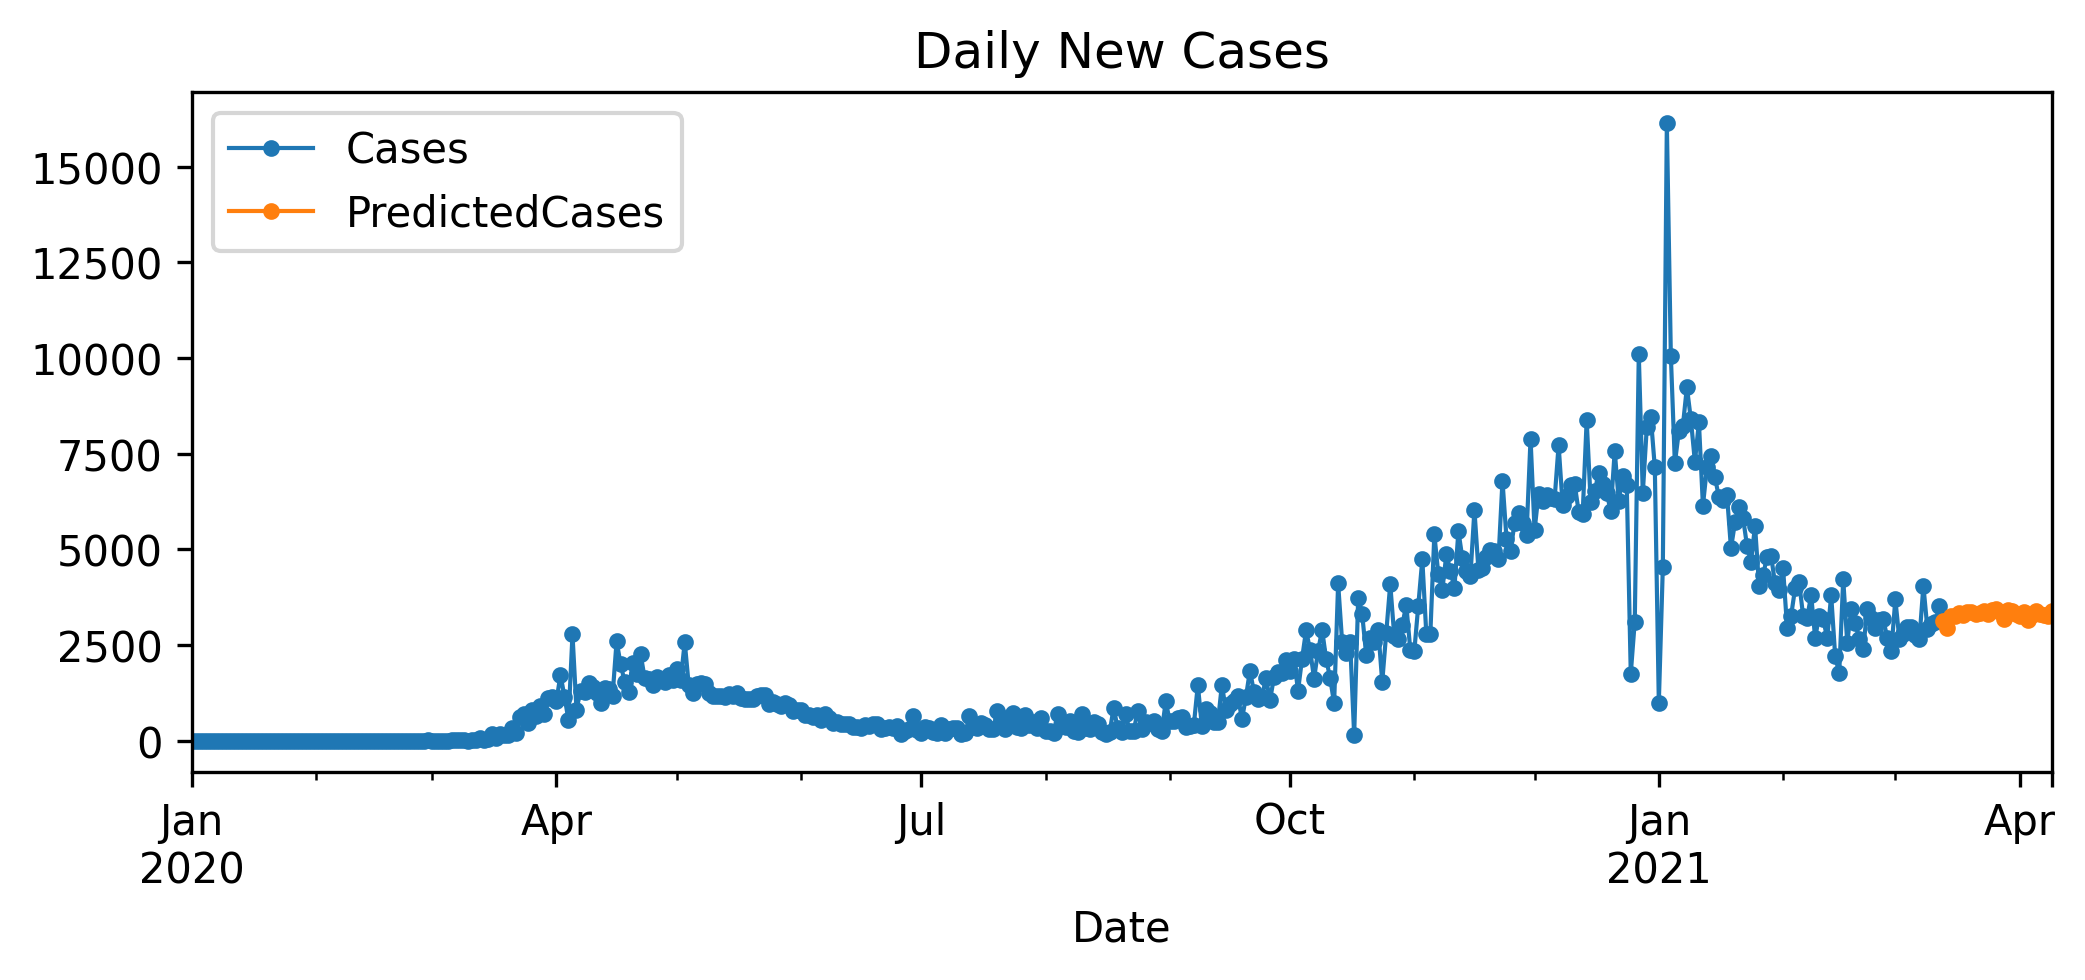

In [8]:
# do not use death number and policy, it is univariate prediction
df_train = train_data(d_CA, ['Cases'], '2021-03-12', is_non_target = False, is_policy = False)
df_future = []
for gap in [0, 7, 14, 21]:
    df_forecast = direct_forecast(df_train, ['Cases'], gap = gap)
    df_future.append(df_forecast)
df_future = pd.concat([df for df in df_future])
daily_report(df_train, df_future, ['Cases'])

## Death Forecast (Multivariate)

297 New Deaths between 2021-03-13 and 2021-03-19
259 New Deaths between 2021-03-20 and 2021-03-26
258 New Deaths between 2021-03-27 and 2021-04-02
301 New Deaths between 2021-04-03 and 2021-04-09


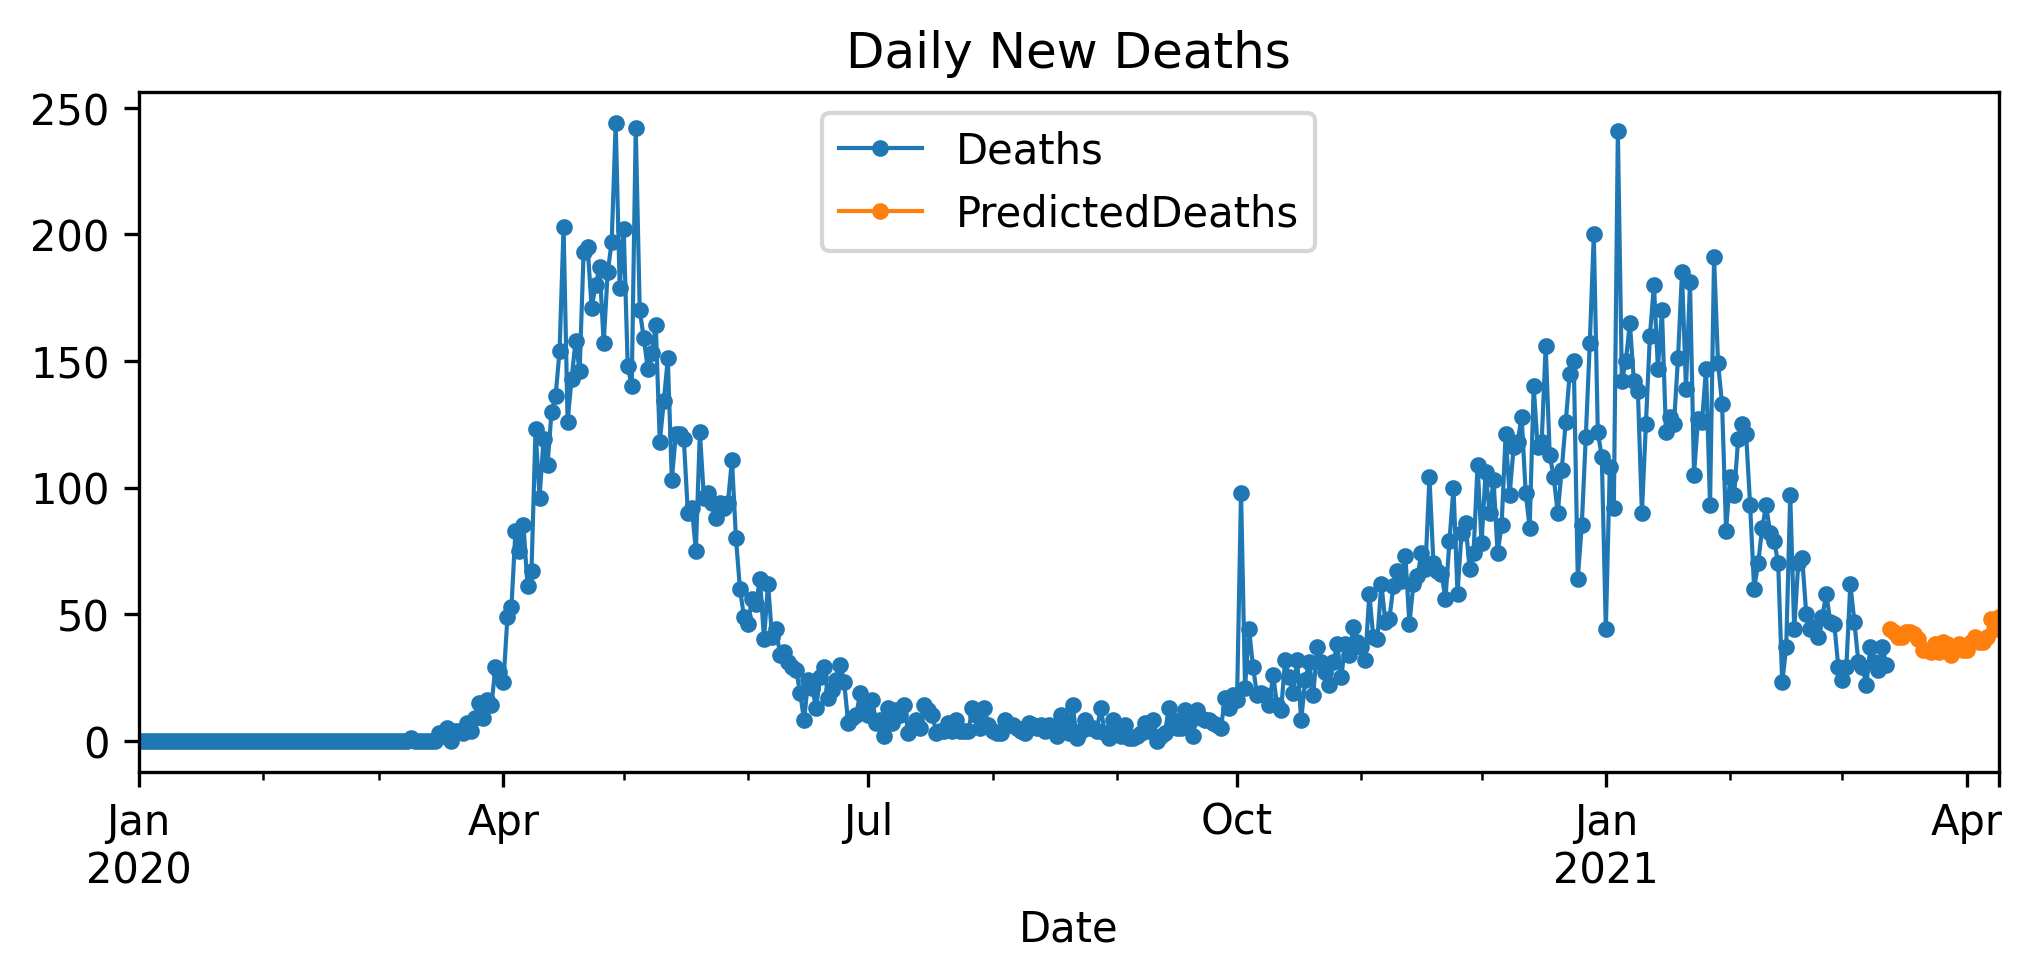

In [9]:
# use case number as covariate
df_train = train_data(d_CA, ['Deaths'], '2021-03-12', is_non_target = True, is_policy = False)
df_future = []
for gap in [0, 7, 14, 21]:
    df_forecast = direct_forecast(df_train, ['Deaths'], gap = gap)
    df_future.append(df_forecast)
df_future = pd.concat([df for df in df_future])
daily_report(df_train, df_future, ['Deaths'])